In [ ]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os
import torch
import torch.nn.functional as F

# ## Initialize Model
from rnn_lib import utils
from rnn_lib.base_rnn import RNNCell
from rnn_lib.model import Model
from rnn_lib.dense_layers import DenseLayer
from rnn_lib.init_policies import W_TorchInit, U_TorchInit

#### song
from rnn_lib.dense_layers import ColumnEiDense
from rnn_lib.song_rnn import ColumnEiCell
from rnn_lib.init_policies import ColumnEi_FirstCell_U_InitPolicy, ColumnEiCell_W_InitPolicy
from rnn_lib.update_policies import ColumnEiSGD_Clip, ColumnEiDenseSGD

#### danns
from rnn_lib.dense_layers import EiDense
from rnn_lib.dann_rnn import EiRNNCell
from rnn_lib.init_policies import EiDenseWeightInit_WexMean, EiRNNCell_W_InitPolicy
# from rnn_lib.update_policies import EiRNN_cSGD_UpdatePolicy, DalesANN_cSGD_UpdatePolicy

In [2]:
# Load saved models and results
PLAYGROUND_DIR = "~/logs/EI_RLDM/decision_making"
models_dir = f"{PLAYGROUND_DIR}/saved_models"
results_dir = f"{PLAYGROUND_DIR}/saved_results"
dataset_path   = f"{PLAYGROUND_DIR}/datasets/decision_making_data.npz"

n_output_classes = 2
n_hidden = 125

n_epochs = 600  # Adjust based on training epochs
batch_size = 200
n_seeds = 50
seeds = [i for i in range(n_seeds)]
grad_clip_list = [1, 5, 10]
# rad_list = [0.4+0.4*i for i in range(7)]
rad_list = [1.2]
lr_list = [1e-3, 6e-4, 4e-4, 2e-4, 1e-4]
ei_ratio_list = [4]
para_comb = list(itertools.product(seeds, lr_list, grad_clip_list, rad_list, ei_ratio_list)) # 
(_, _, _, rad, ei_ratio) = para_comb[0]

lr_gc_list = list(itertools.product(lr_list, grad_clip_list))
# Initialize dictionaries to store losses
models = {i: {
    "rnn": {}, 
    "colei": {}, 
    "danns": {}
} for i, _ in enumerate(lr_gc_list)}
num_trials = 100
time_steps = 60
num_outputs = 2

# Task hyperparams
stimulus_onset    = 10
stimulus_duration = 21
test_size         = 100
valid_size        = 100
batch_size        = 200
device            = 'cpu'


# ## Set Hyperparameters
input_features = 2
n_output_classes = 2
ei_ratio = 4     # your E/I ratio
n_hidden = 125   # same as you trained with
rad = 1.2
device = 'cpu'

In [3]:
# Cell 1: Load Dataset & Split Train/Val/Test

data = np.load(dataset_path)
inputs_series    = data['inputs_series']
targets_series   = data['targets_series']
mask_series      = data['mask_series']
coherence_series = data['coherence_series']

# Train / Val / Test split
data_train   = inputs_series[: -valid_size - test_size]
targets_train= targets_series[: -valid_size - test_size]
masks_train   = mask_series[: -valid_size - test_size]
coherence_train = coherence_series[: -valid_size - test_size]

data_valid   = inputs_series[-valid_size - test_size : -test_size]
targets_valid= targets_series[-valid_size - test_size : -test_size]

data_test    = torch.from_numpy(inputs_series[-test_size:]).float().to(device)
targets_test = torch.from_numpy(targets_series[-test_size:]).float().to(device)


In [4]:

for i, (lr, gc)  in enumerate(lr_gc_list):
    for model_type in models[i].keys():
        models[i][model_type] = {k: np.zeros((n_seeds, n_epochs)) for k in ["test_loss", "train_loss", "accuracy", "valid_trial_count"]}
        
        for seed in seeds:
            if model_type == "colei":
                batch_seed_results_dir = f"{results_dir}/batch_size-{batch_size}/seed-{seed}"
                batch_seed_model_dir = f"{models_dir}/batch_size-{batch_size}/seed-{seed}"
                fname_results = f"dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{lr}_GC{gc}_adam.npz"
                fname_model = f"dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{lr}_GC{gc}_adam.pth"
                results_path = batch_seed_results_dir + "/" + fname_results
            else:
                batch_seed_model_dir = f"{models_dir}/batch_size-{batch_size}/seed-{seed}"
                batch_seed_results_dir = f"{results_dir}/batch_size-{batch_size}/seed-{seed}"
                fname_results = f"dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{lr}_GC{gc}_adam.npz"
                fname_model = f"dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{lr}_GC{gc}_adam.pth"
                results_path = batch_seed_results_dir + "/" + fname_results

            if os.path.exists(results_path):
                data = np.load(results_path)
                try:
                    models[i][model_type]["train_loss"][seed, :] = data["train_loss"][:n_epochs]
                    models[i][model_type]["test_loss"][seed, :] = data["test_loss"][:n_epochs]
                    models[i][model_type]["accuracy"][seed, :] = data["accuracy"][:n_epochs]
                    models[i][model_type]["valid_trial_count"][seed, :] = data["valid_trial_count"][:n_epochs]
                except Exception as e: 
                    print(e)
                    print(results_path)
            else:
                print(f"Warning: Missing results file {results_path}")

In [6]:

# Compute mean and standard deviation across seeds
train_loss_mean = {i: {model: np.mean(models[i][model]["train_loss"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
train_loss_std = {i: {model: np.std(models[i][model]["train_loss"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
test_loss_mean = {i: {model: np.mean(models[i][model]["test_loss"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
test_loss_std = {i: {model: np.std(models[i][model]["test_loss"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
accuracy_mean = {i: {model: np.mean(models[i][model]["accuracy"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
accuracy_mean2 = {i: {model: np.mean(np.trapz(models[i][model]["accuracy"], axis=-1), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
accuracy_std2 = {i: {model: np.std(np.trapz(models[i][model]["accuracy"], axis=-1), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
accuracy_std = {i: {model: np.std(models[i][model]["accuracy"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
valid_trials_mean = {i: {model: np.mean(models[i][model]["valid_trial_count"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
valid_trials_std = {i: {model: np.std(models[i][model]["valid_trial_count"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}

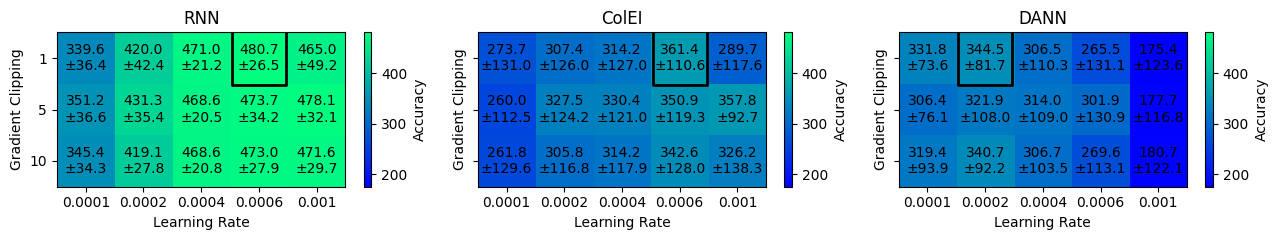

In [7]:
# Plot results
labels = {
    "rnn": "RNN", 
          "colei": "ColEI", 
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '-', '-','-','-','-','-']#,'--', ':', "-."]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
fig, axes = plt.subplots(1, 3, figsize=(13, 2.5), sharey='row', sharex=False, squeeze=False)

all_loss_values = {model_type: [] for model_type in labels.keys()}

ax = axes[0, :]
loss_mean = accuracy_mean2
loss_std = accuracy_std2
linestyle = linestyles[0]
mins = []
maxs = []
heatmaps = {}
scores = {}
# for i, (lr, linestyle) in enumerate(zip(lr_list, linestyles)):
for j, model_type in enumerate(labels.keys()):

    # Convert lr_gc_list and loss_mean into structured arrays
    lr_values = sorted(set(lr for lr, gc in lr_gc_list))  # Unique sorted learning rates
    gc_values = sorted(set(gc for lr, gc in lr_gc_list))  # Unique sorted gradient clipping values

    # Create a 2D array for accuracy values
    heatmap_matrix = np.full((len(gc_values), len(lr_values)), np.nan)  # Initialize with NaNs
    # Create 2D arrays for accuracy and std values
    std_matrix = np.full((len(gc_values), len(lr_values)), np.nan)  # Standard deviation values
    score_matrix = np.full((len(gc_values), len(lr_values)), np.nan)  # Mean - std values

    loss_values = np.array([loss_mean[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list)])
    # Fill matrices
    for i, (lr, gc) in enumerate(lr_gc_list):
        row = gc_values.index(gc)
        col = lr_values.index(lr)
        mean_val = loss_mean[i][model_type]  # Accuracy
        std_val = loss_std[i][model_type]  # Standard deviation
        heatmap_matrix[row, col] = mean_val
        std_matrix[row, col] = std_val
        score_matrix[row, col] = mean_val - std_val  # Mean - std score
    
    # Define common colormap range
    vmin = min(np.nanmin(heatmap_matrix), np.nanmin(std_matrix), np.nanmin(score_matrix))
    vmax = max(np.nanmax(heatmap_matrix), np.nanmax(std_matrix), np.nanmax(score_matrix))
    mins.append(np.nanmin(heatmap_matrix))
    maxs.append(np.nanmax(heatmap_matrix)) 
    heatmaps[model_type] = heatmap_matrix
    scores[model_type] = score_matrix
    # Set tick labels
    ax[j].set_xticks(np.arange(len(lr_values)))
    ax[j].set_yticks(np.arange(len(gc_values)))
    ax[j].set_xticklabels(lr_values)
    ax[j].set_yticklabels(gc_values)

    # Labels
    ax[j].set_xlabel("Learning Rate")
    ax[j].set_ylabel("Gradient Clipping")

    # Annotate cells with mean ± std
    for i in range(len(gc_values)):
        for k in range(len(lr_values)):
            value = heatmap_matrix[i, k]
            std = std_matrix[i, k]
            if not np.isnan(value):
                ax[j].text(k, i, f"{value:.1f}\n±{std:.1f}", ha="center", va="center", 
                        color="white" if value < np.max(heatmap_matrix) / 2 else "black")

vmin = np.min(mins)
vmax = np.max(maxs)
for j, model_type in enumerate(labels.keys()):
    cax = ax[j].imshow(heatmaps[model_type], cmap=plt.cm.winter, aspect="auto", vmin=vmin, vmax=vmax)

    # Find best (mean - std) location
    # best_idx = np.unravel_index(np.argmax(scores[model_type]), scores[model_type].shape)
    best_idx = np.unravel_index(np.argmax(heatmaps[model_type]), heatmaps[model_type].shape)

    # Add colorbar
    cbar = plt.colorbar(cax, ax=ax[j])
    cbar.set_label("Accuracy")
    ax[j].set_title(labels[model_type])
    # Highlight best (mean - std) value
    ax[j].scatter(best_idx[1], best_idx[0], marker="s", s=1500, facecolors='none', edgecolors='k', linewidths=2)
plt.tight_layout()
plt.show()

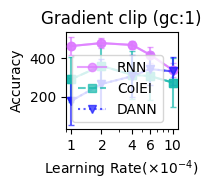

: 

In [ ]:
# Plot results
import matplotlib.ticker as ticker
labels = {"rnn": "RNN", 
          "colei": "ColEI", 
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '--', ':', "-."]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
fig, axes = plt.subplots(1, 1, figsize=(2, 2), sharey=True, sharex=True, squeeze=False)
colors = ["#dd7aff", "#17b9ad", "#1a1aff" ]
all_loss_values = {model_type: [] for model_type in labels.keys()}

ax = axes[0, :]
loss_mean = accuracy_mean2
loss_std = accuracy_std2
ax[0].set_ylabel("Accuracy")
markers = ["o", "s", "v", "x"]
mins = []
maxs = []
heatmaps = {}
scores = {}
j = 0
gc_p = 1
for k, model_type in enumerate(labels.keys()):
    # Extract unique learning rates
    lr_values = sorted(set(lr for lr, gc in lr_gc_list))
    gc_values = sorted(set(gc for lr, gc in lr_gc_list))

    # Select the index corresponding to gradient clipping = 1
    gc_index = gc_values.index(gc_p)

    # Extract loss values for gradient clipping = 1
    loss_values = np.array([loss_mean[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    std_values = np.array([loss_std[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    # Plot the U-curve
    ax[j].plot(lr_values, loss_values, label=f"{labels[model_type]}",  marker=markers[k], color=colors[k], linestyle=linestyles[k], alpha=0.7, zorder=3)
    ax[j].errorbar(lr_values, loss_values, yerr=std_values, color=colors[k], marker=markers[k], capsize=2, alpha=0.7)
    ax[j].set_title("Gradient clip " + f"(gc:{gc_p})")
    ax[j].set_xlabel("Learning Rate" + f"$(\\!\\times\\!10^{{\\!-\\!4}})$")
    ax[j].set_xscale("log")  # Assuming learning rates are logarithmically spaced

    ax[j].set_xticks(lr_values)
   
    ax[j].legend()
    
 
    ax[j].set_xticklabels([f'${round(tick*(10**4))}$' for tick in lr_values])
plt.tight_layout()
plt.show()

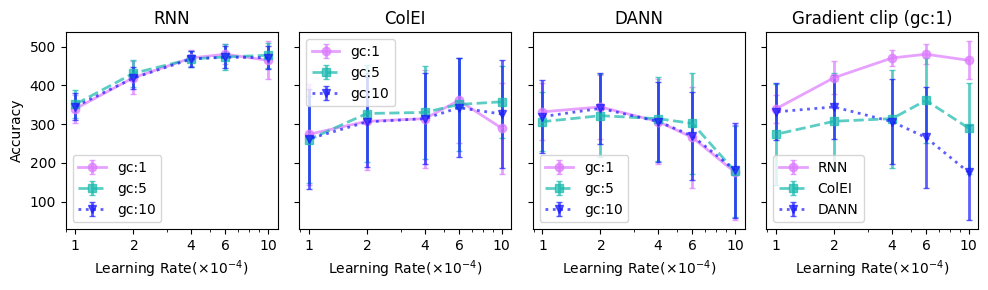

In [9]:
# Plot results
import matplotlib.ticker as ticker
labels = {"rnn": "RNN", 
          "colei": "ColEI", 
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '--', ':', "-."]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharey=True, sharex=True, squeeze=False)
colors = ["#dd7aff", "#17b9ad", "#1a1aff" ]
all_loss_values = {model_type: [] for model_type in labels.keys()}

ax = axes[0, :]
loss_mean = accuracy_mean2
loss_std = accuracy_std2
markers = ["o", "s", "v", "x"]
mins = []
maxs = []
heatmaps = {}
scores = {}
for j, model_type in enumerate(labels.keys()):

    for k, gc_p in enumerate(gc_values):
        # Select the index corresponding to gradient clipping = 1
        lr_values2 = np.array([lr for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
        # Extract loss values for gradient clipping = 1
        loss_values = np.array([loss_mean[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
        std_values = np.array([loss_std[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
        # Plot the U-curve
        ax[j].errorbar(lr_values2, loss_values, yerr=std_values, label=f"gc:{gc_p}", color=colors[k], marker=markers[k],  lw=2,linestyle=linestyles[k], capsize=2, alpha=0.7)
    ax[j].set_title(labels[model_type])
    ax[j].set_xlabel("Learning Rate"+ f"$(\\!\\times\\!10^{{\\!-\\!4}})$")
    ax[j].set_xscale("log")  # Assuming learning rates are logarithmically spaced

    ax[j].set_xticks(lr_values2)
    
    ax[j].legend()
    ax[j].set_xticklabels([f'${round(tick*(10**4))}\\!\\cdot\\!10^{{\\!-\\!4}}$' for tick in lr_values2])
    
ax[0].set_ylabel("Accuracy")
j = 3
gc_p = 1
for k, model_type in enumerate(labels.keys()):

    # Extract loss values for gradient clipping = 1
    loss_values = np.array([loss_mean[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    std_values = np.array([loss_std[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    lr_values2 = np.array([lr for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    # Plot the U-curve
    # ax[j].plot(lr_values, loss_values, label=f"{labels[model_type]}",  marker=markers[k], color=colors[k], linestyle=linestyles[k], alpha=0.7, zorder=3)
    ax[j].errorbar(lr_values2, loss_values, yerr=std_values, label=f"{labels[model_type]}", color=colors[k], marker=markers[k], capsize=2, linestyle=linestyles[k], lw=2, alpha=0.7, zorder=3)
    ax[j].set_title("Gradient clip " + f"(gc:{gc_p})")
    ax[j].set_xlabel("Learning Rate" + f"$(\\!\\times\\!10^{{\\!-\\!4}})$")
    ax[j].set_xscale("log")  # Assuming learning rates are logarithmically spaced

    ax[j].set_xticks(lr_values2)
    ax[j].legend()
    
    # Customize tick locator to show all labels in the range you want
    # ax[j].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=len(lr_values)))
    ax[j].set_xticklabels([f'${round(tick*(10**4))}$' for tick in lr_values2])
    # Optionally, force the display of specific ticks
    # ax[j].set_xticklabels([f'${round(tick*(10**4))}\\!\\cdot\\!10^{{\\!-\\!4}}$' for tick in lr_values])
plt.tight_layout()
plt.show()


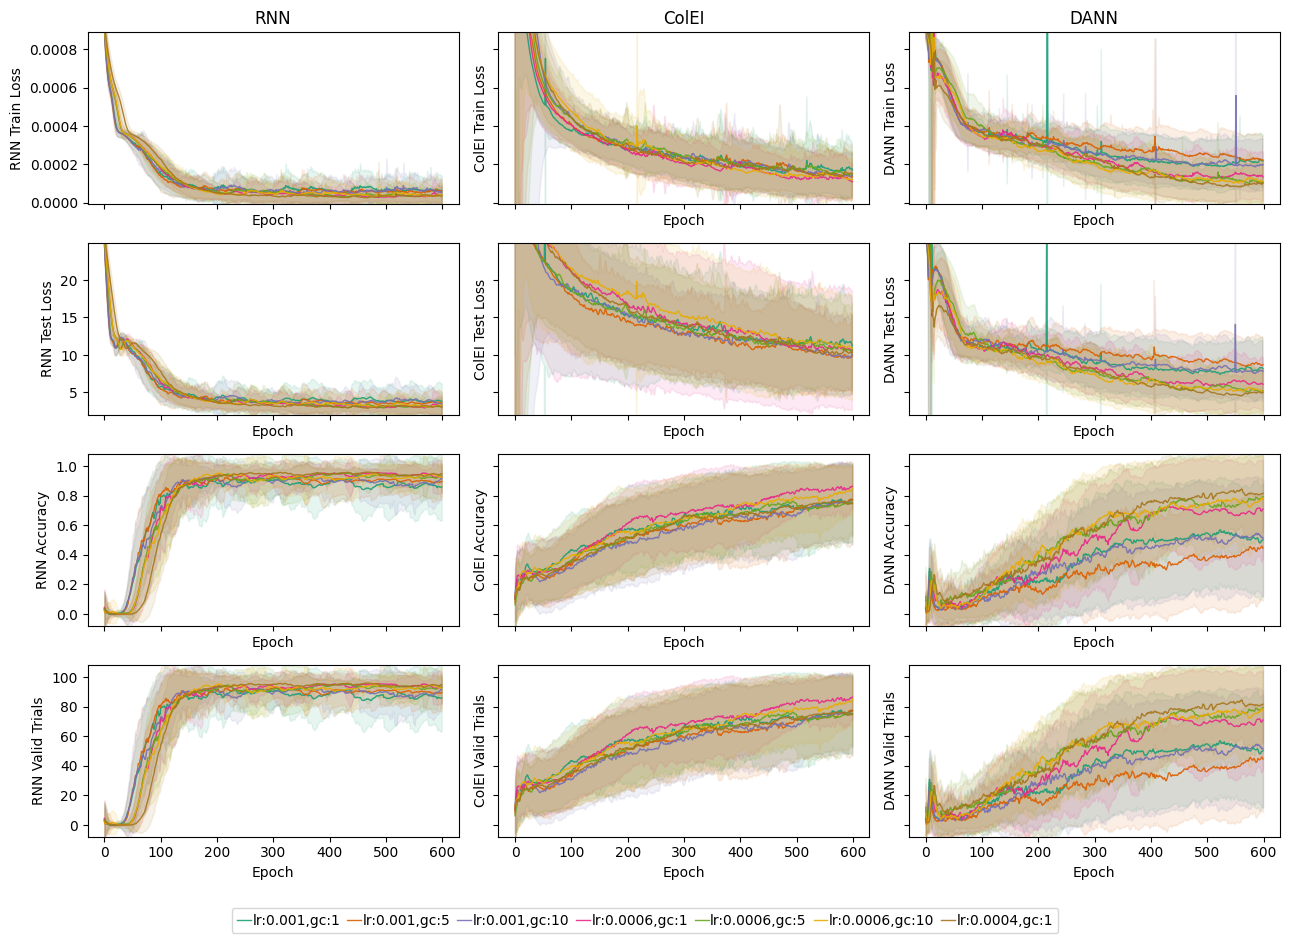

In [ ]:
# Plot results
labels = {"rnn": "RNN", 
          "colei": "ColEI", 
          "danns": "DANN"}
COLORS = plt.get_cmap('Dark2').colors
linestyles = ['-', '-', '-','-','-','-','-']#,'--', ':', "-."]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
fig, axes = plt.subplots(4, 3, figsize=(13, 9), sharey='row', sharex=True)

# Training Loss

### Helper Function to Plot with Dynamic Y-Limits ###
def plot_metric(ax, loss_mean, loss_std, title, y_label, plot_x_label=True):
    all_loss_values = {model_type: [] for model_type in labels.keys()}

    for i, ((lr, gc), linestyle) in enumerate(zip(lr_gc_list, linestyles)):
        for j, model_type in enumerate(models[i].keys()):
            loss_values = loss_mean[i][model_type]
            std_values = loss_std[i][model_type]

            # Collect values for dynamic y-limit computation
            all_loss_values[model_type].extend(loss_values - std_values)
            all_loss_values[model_type].extend(loss_values + std_values)

            # Plot mean and std range
            ax[j].plot(loss_values, label=f"lr:{lr},gc:{gc}", color=colors[i], linestyle=linestyles[i],lw=1, alpha=0.9, zorder=2)
            ax[j].fill_between(range(n_epochs), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.1)

    for j, model_type in enumerate(models[i].keys()):
        ax[j].set_xlabel("Epoch")
        ax[j].set_ylabel(f"{labels[model_type]} {y_label}")
        # ax[j].legend()

        # Apply dynamic y-limits (ignore NaN, remove extreme outliers)
        all_loss_values[model_type] = np.nan_to_num(all_loss_values[model_type], nan=0)
        y_min, y_max = np.percentile(all_loss_values[model_type], [1, 99])
        ax[j].set_ylim(y_min, y_max)

for j, model_type in enumerate(labels.keys()):
    axes[0, j].set_title(f"{labels[model_type]}")

### **Train Loss Plot (Row 1, Col 0)**
plot_metric(axes[0, :], train_loss_mean, train_loss_std, "Train Loss", "Train Loss", plot_x_label=False)

### **Test Loss Plot (Row 1, Col 1)**
plot_metric(axes[1, :], test_loss_mean, test_loss_std, "Test Loss", "Test Loss", plot_x_label=False)

### **Accuracy Plot (Row 2, Col 0)**
plot_metric(axes[2, :], accuracy_mean, accuracy_std, "Accuracy", "Accuracy", plot_x_label=False)

### **Valid Trials Plot (Row 2, Col 1)**
plot_metric(axes[3, :], valid_trials_mean, valid_trials_std, "Valid Trials", "Valid Trials")


handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels,
            loc='lower center',
            ncol=len(unique_labels),
            handlelength=1, 
            handletextpad=0.1, 
            # ncol=4, 
            columnspacing=0.5,
            bbox_to_anchor=(0.5, -0.05))

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0., 1, 1])
plt.show()